In [1]:
#Importing Dependancies
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input


In [2]:
#seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
#reading data
#Change path to your images and csv files path 
train_data = pd.read_csv('./Train.csv')
test_data = pd.read_csv('./Test.csv')
train_path = './train/'
test_path = './test/'



In [4]:
#creating train and test dataframe
#we will create dataframes and use keras Image data preprocessing function: flow_from_dataframe

# train
train_names = train_data.ID.values
train_labels = np.asarray(train_data['LABEL'].values)
train_dict = {'filepath': train_path + train_names + '.png', 'LABEL': train_labels}
train = pd.DataFrame(data=train_dict)
train['ID'] = train_data['ID']
train['LABEL'] = train.LABEL.apply(lambda x: 'Positive' if x == 1 else 'Negative')

# test
test_names = test_data.ID.values
test_dict = {'filepath': test_path + test_names + '.png'}
test = pd.DataFrame(data=test_dict)
test['ID'] = test_data['ID']

train

,filepath,LABEL,ID
0,./train/VTYNBFTO.png,Positive,VTYNBFTO
1,./train/GVVXXDOZ.png,Negative,GVVXXDOZ
2,./train/PMRSQLXN.png,Negative,PMRSQLXN
3,./train/JXISWDUU.png,Positive,JXISWDUU
4,./train/JVWMAACC.png,Positive,JVWMAACC
...,...,...,...
713,./train/EWGJDECH.png,Positive,EWGJDECH
714,./train/CJEVKQUT.png,Positive,CJEVKQUT
715,./train/YDXXBDGI.png,Positive,YDXXBDGI
716,./train/QLUOORWZ.png,Negative,QLUOORWZ


In [5]:
#Viewing the train dataframe
train.head()

,filepath,LABEL,ID
0,./train/VTYNBFTO.png,Positive,VTYNBFTO
1,./train/GVVXXDOZ.png,Negative,GVVXXDOZ
2,./train/PMRSQLXN.png,Negative,PMRSQLXN
3,./train/JXISWDUU.png,Positive,JXISWDUU
4,./train/JVWMAACC.png,Positive,JVWMAACC


In [6]:
#Viewing the test dataframe
test.head()

,filepath,ID
0,./test/GTWSHFYQ.png,GTWSHFYQ
1,./test/QTFSSMGD.png,QTFSSMGD
2,./test/TBLBHSYT.png,TBLBHSYT
3,./test/ZKETEOFG.png,ZKETEOFG
4,./test/GKTPBGZP.png,GKTPBGZP


In [7]:
#Checking the shape of these dataframes to see the number of images
train.shape, test.shape

((718, 3), (82, 2))

/home/kali/anaconda3/envs/GPUml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


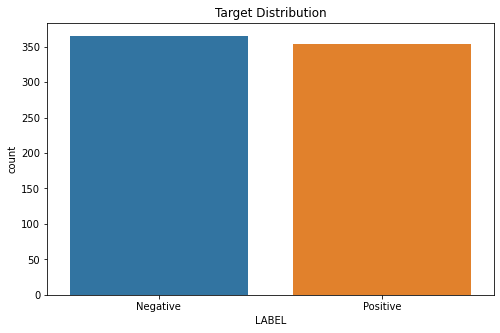

In [8]:
#visualizing target distribution 
f, ax = plt.subplots(1,1, figsize=(8,5))
sns.countplot(train['LABEL'],order = train['LABEL'].value_counts().index)
plt.title("Target Distribution")
plt.show()



In [9]:
#we can see that our dataset is balanced with almost equal number of samples in each class
train.LABEL.value_counts()/len(train)

Negative    0.508357
Positive    0.491643
Name: LABEL, dtype: float64

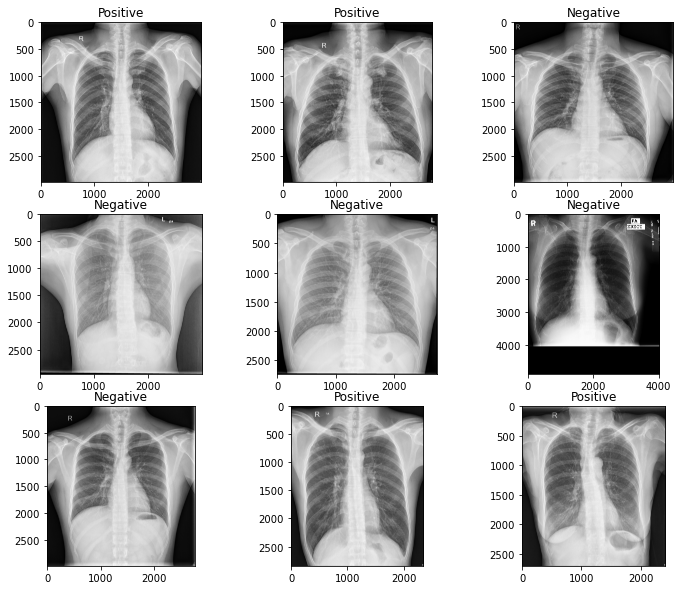

In [10]:

#visualizing random images
nrows = 3
rands = np.random.randint(train.shape[0], size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(train.loc[rands[i], 'filepath'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'LABEL'])
plt.show()


In [11]:
#lets split our training data into train and validation set
#We have 718 training samples and i will use 80% train and 20% validation  
df_train = train[:575:]
df_val = train[575:]
print(df_train.LABEL.value_counts())
print(df_val.LABEL.value_counts())

Negative    295
Positive    280
Name: LABEL, dtype: int64
Positive    73
Negative    70
Name: LABEL, dtype: int64


In [12]:
#Creating data generators
batch_size = 32  
image_size = (224, 224)
learning_rate = 0.0001

train_steps = np.ceil(len(df_train) / batch_size)
val_steps = np.ceil(len(df_val) / batch_size )

classes = train.LABEL.unique().tolist()

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,horizontal_flip=True,
                             vertical_flip=True,shear_range=10,zoom_range=0.2,width_shift_range=0.1,
                             height_shift_range=0.1,channel_shift_range=10.)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_datagen.flow_from_dataframe(df_train,x_col='filepath', y_col='LABEL',
                                        target_size=image_size,classes=classes,
                                        batch_size=batch_size,
                                        class_mode='categorical', shuffle=True, seed=SEED)

val_ds = val_datagen.flow_from_dataframe(df_val,x_col='filepath', y_col='LABEL',
                                        target_size=image_size,classes=classes,
                                        batch_size=batch_size,
                                        class_mode='categorical', shuffle=False, seed=SEED)

test_ds = val_datagen.flow_from_dataframe(test, x_col='filepath',target_size=image_size, class_mode=None,
                                          shuffle=False,batch_size=batch_size)#set shuffle=False for test dataset not be shuffled



Found 575 validated image filenames belonging to 2 classes.
Found 143 validated image filenames belonging to 2 classes.
Found 82 validated image filenames.


In [13]:
#we will use transfer learning from ResNet50 model

def BuildModel (pretrained=ResNet50):

    base_model = pretrained(include_top=False, weights='imagenet', input_shape=(224, 224,3)) #include_top=False to remove the last layer 

    for layer in base_model.layers:
        layer.trainable = False   #freeze trainable layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Dense(3072, activation='relu', )(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    output = Dense(2, activation='sigmoid')(x) 
    
    model = Model(base_model.input, output)
    
    return model


In [14]:
#Actually building and compiling the model
model = BuildModel()

#compile model
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC'])

In [15]:
#callbacks
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
chkpt_path = os.path.join("./", f"tb_model.h5", )
checkpoint = ModelCheckpoint(chkpt_path, monitor='val_loss',mode='auto', verbose=1, save_best_only=True,)


In [16]:
#fit model
history = model.fit(train_ds, epochs=15,steps_per_epoch=train_steps, callbacks=[earlystop, checkpoint],
                    verbose=1, shuffle=False,validation_data=(val_ds), validation_steps= val_steps)

Epoch 1/15
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
18/18 [==============================] - ETA: 0s - loss: 0.7227 - auc: 0.6886
Epoch 00001: val_loss improved from inf to 0.60939, saving model to ./tb_model.h5
18/18 [==============================] - 58s 3s/step - loss: 0.7227 - auc: 0.6886 - val_loss: 0.6094 - val_auc: 0.8088
Epoch 2/15
18/18 [==============================] - ETA: 0s - loss: 0.5985 - auc: 0.7943
Epoch 00002: val_loss did not improve from 0.60939
18/18 [==============================] - 51s 3s/step - loss: 0.5985 - auc: 0.7943 - val_loss: 0.6123 - val_auc: 0.7545
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 0.5306 - auc: 0.8345
Epoch 00003: val_loss improved from 0.60939 to 0.54058, saving model to ./tb_model.h5
18/18 [==============================] - 52s 3s/step - loss: 0.5306 - auc: 0.8345 - val_loss: 0.5406 - val_auc: 0.8117
Epoch 4/15
18/18 [==============================] - ETA: 0s - loss: 0.5183 -

In [17]:
#AUC
y_pred = model.predict(val_ds,verbose=1)[:, 1] 
fpr, tpr, thresholds = roc_curve(val_ds.classes, y_pred)
auc = auc(fpr, tpr)
auc

    666/Unknown - 1229s 2s/step

KeyboardInterrupt: 

In [ ]:
## plotting AUC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()



In [ ]:
#make predictions on test data
predictions = model.predict(test_ds,verbose=1)


In [ ]:
submission = pd.DataFrame()
submission['ID'] = test['ID']
submission['LABEL'] = predictions

In [ ]:
submission

In [ ]:


submission.to_csv('starter1.csv', index=False)

